In [54]:
import os
import shutil
from PIL import Image
import pandas as pd
import numpy as np
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input

# converting the gifs and webp into jpg

source_dir = "/kaggle/input/soil-classification/soil_classification-2025/train"
dest_dir = "/tmp/train"
os.makedirs(dest_dir, exist_ok=True)

valid_exts = ('.jpg', '.jpeg', '.png')

for filename in os.listdir(source_dir):
    src_path = os.path.join(source_dir, filename)
    name_wo_ext, ext = os.path.splitext(filename)
    try:
        if ext in valid_exts:
            # copying directly for valid extensions
            shutil.copy2(src_path, os.path.join(dest_dir, filename))

        elif ext in ('.gif', '.webp'):
            # Convertting to .jpg
            img = Image.open(src_path).convert("RGB")
            new_name = f"{name_wo_ext}.jpg"
            img.save(os.path.join(dest_dir, new_name))

        else:
            print(f"skip: {filename}")

    except Exception as e:
        print(f"error {filename}: {e}")

print("Cleaned folder created at:", dest_dir)


source_dir = "/kaggle/input/soil-classification/soil_classification-2025/test"
dest_dir = "/tmp/test"
os.makedirs(dest_dir, exist_ok=True)


for filename in os.listdir(source_dir):
    src_path = os.path.join(source_dir, filename)
    name_wo_ext, ext = os.path.splitext(filename)

    try:
        if ext in valid_exts:
            shutil.copy2(src_path, os.path.join(dest_dir, filename))

        elif ext in ('.gif', '.webp'):
            img = Image.open(src_path).convert("RGB")
            new_name = f"{name_wo_ext}.jpg"
            img.save(os.path.join(dest_dir, new_name))

        else:
            print(f"skip: {filename}")

    except Exception as e:
        print(f"error {filename}: {e}")

print("Cleaned folder created at:", dest_dir)

Cleaned folder created at: /tmp/train
Cleaned folder created at: /tmp/test


In [55]:
df = pd.read_csv('/kaggle/input/soil-classification/soil_classification-2025/train_labels.csv')
df.head()

,image_id,soil_type
0,img_ed005410.jpg,Alluvial soil
1,img_0c5ecd2a.jpg,Alluvial soil
2,img_ed713bb5.jpg,Alluvial soil
3,img_12c58874.jpg,Alluvial soil
4,img_eff357af.jpg,Alluvial soil


In [56]:
df['image_id'] = df['image_id'].str.replace(r'\.webp$', '.jpg', regex=True)
df['image_id'] = df['image_id'].str.replace(r'\.gif$', '.jpg', regex=True)

In [57]:
df.soil_type.value_counts()

soil_type
Alluvial soil    528
Red soil         264
Black Soil       231
Clay soil        199
Name: count, dtype: int64

In [58]:
from sklearn.model_selection import train_test_split

# Mapping soil_type to integer labels
class_names = sorted(df['soil_type'].unique())
class_to_idx = {name: idx for idx, name in enumerate(class_names)}
df['soil_index'] = df['soil_type'].map(class_to_idx)

# Splitting with stratification
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df['soil_index'], random_state=42
)

print("Training set class distribution:\n", train_df['soil_type'].value_counts())
print("\nValidation set class distribution:\n", val_df['soil_type'].value_counts())

Training set class distribution:
 soil_type
Alluvial soil    422
Red soil         211
Black Soil       185
Clay soil        159
Name: count, dtype: int64

Validation set class distribution:
 soil_type
Alluvial soil    106
Red soil          53
Black Soil        46
Clay soil         40
Name: count, dtype: int64


In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (384, 384)
batch_size = 16

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Using the stratiffied split
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/tmp/train',
    x_col='image_id',
    y_col='soil_type',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='/tmp/train',
    x_col='image_id',
    y_col='soil_type',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 977 validated image filenames belonging to 4 classes.
Found 245 validated image filenames belonging to 4 classes.


In [60]:
print("Classes in training subset:", np.unique(train_generator.classes))
print("Classes in validation subset:", np.unique(val_generator.classes))

Classes in training subset: [0 1 2 3]
Classes in validation subset: [0 1 2 3]


In [61]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=14, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)
]

In [62]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB3

base_model = EfficientNetB3(
    weights='imagenet',
    include_top=False,
    input_shape=(384, 384, 3)
)

base_model.trainable = False 

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [63]:
history = model.fit(train_generator, epochs=50, validation_data=val_generator, callbacks=callbacks)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 78s 608ms/step - accuracy: 0.5393 - loss: 1.0721 - val_accuracy: 0.9020 - val_loss: 0.5148 - learning_rate: 1.0000e-04
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.8114 - loss: 0.5751 - val_accuracy: 0.9306 - val_loss: 0.3566 - learning_rate: 1.0000e-04
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.8868 - loss: 0.4094 - val_accuracy: 0.9388 - val_loss: 0.2867 - learning_rate: 1.0000e-04
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9094 - loss: 0.3409 - val_accuracy: 0.9388 - val_loss: 0.2452 - learning_rate: 1.0000e-04
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.9229 - loss: 0.2828 - val_accuracy: 0.9469 - val_loss: 0.2166 - learning_rate: 1.0000e-04
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 0.9336 - loss: 0.2460 - val_accuracy: 0.9510 - val_loss: 0.1979 - learning_rate: 1.0000e-04
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.9391 -

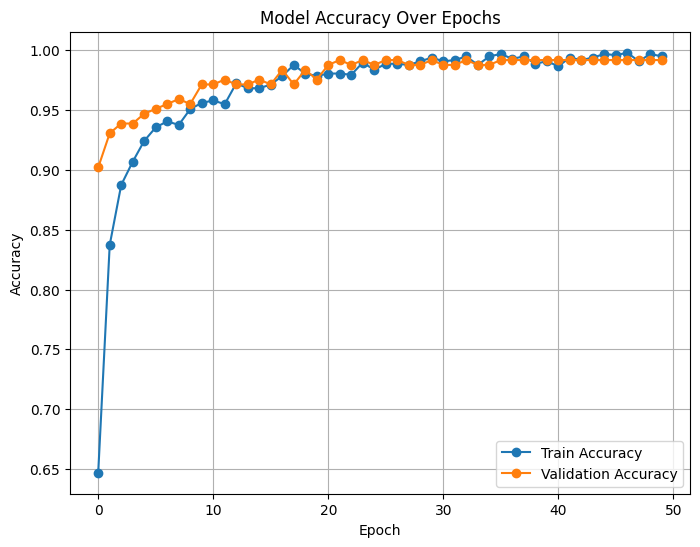

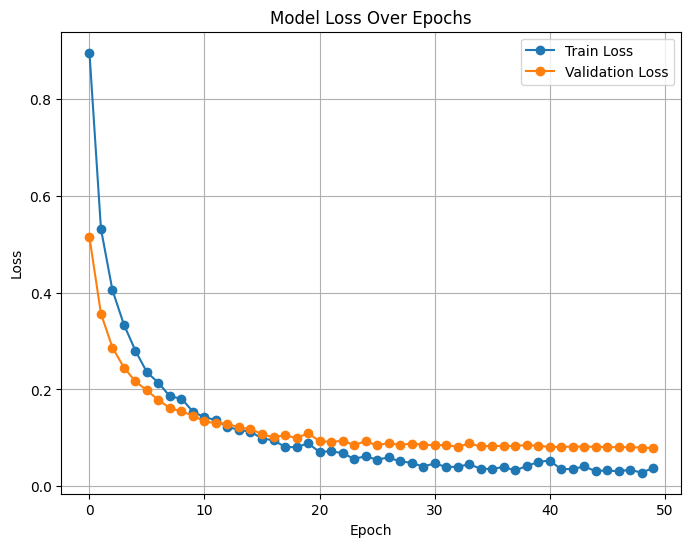

In [64]:
import matplotlib.pyplot as plt

os.makedirs("assets", exist_ok=True)

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("assets/accuracy_plot.png") 
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("assets/loss_plot.png")  
plt.show()

In [65]:
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

val_generator.reset()

val_preds = model.predict(val_generator)
val_preds_classes = np.argmax(val_preds, axis=1)
true_classes = val_generator.classes

class_labels = [None] * len(train_generator.class_indices)
for class_name, index in train_generator.class_indices.items():
    class_labels[index] = class_name

report = classification_report(
    true_classes,
    val_preds_classes,
    target_names=class_labels,
    output_dict=True
)

report_df = pd.DataFrame(report).T

f1_scores = report_df.loc[class_labels, 'f1-score']
print("Class-wise F1-scores:\n")
print(f1_scores)

min_f1_class = f1_scores.idxmin()
min_f1_score = f1_scores.min()
print(f"\nClass with lowest F1-score: '{min_f1_class}' with F1 = {min_f1_score:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 883ms/step
Class-wise F1-scores:

Alluvial soil    0.990476
Black Soil       0.978723
Clay soil        1.000000
Red soil         1.000000
Name: f1-score, dtype: float64

Class with lowest F1-score: 'Black Soil' with F1 = 0.9787


In [66]:
test_df = pd.read_csv("/kaggle/input/soil-classification/soil_classification-2025/test_ids.csv")

def get_processed_filename(filename):
    name_wo_ext, ext = os.path.splitext(filename)
    if ext.lower() in ['.gif', '.webp']:
        return name_wo_ext + '.jpg' 
    else:
        return filename  

test_df['processed_image_id'] = test_df['image_id'].apply(get_processed_filename)

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    dataframe=test_df,
    directory='/tmp/test',
    x_col='processed_image_id', 
    class_mode=None,
    target_size=image_size,
    shuffle=False
)

preds = model.predict(test_gen)
pred_labels = np.argmax(preds, axis=1)
label_map = {v: k for k, v in train_generator.class_indices.items()}
test_df['soil_type'] = [label_map[i] for i in pred_labels]

submission = test_df[['image_id', 'soil_type']]
submission.to_csv("submission.csv", index=False)

Found 341 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step 
